In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
config = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
session = tf.compat.v1.Session(config=config)

In [4]:
# Load Labels
labels_csv = pd.read_csv("labels.csv")
filenames = list("train/" + labels_csv["id"] + ".jpg")
unique_breeds = np.unique(labels_csv['breed'])
labels = list(labels_csv["breed"])
boolean_labels = [lab == unique_breeds for lab in labels]

# Define Features and Target
x = filenames
y = list(boolean_labels)
num_images = 6500

# Split into Train and Validation Sets
tx, vx, ty, vy = train_test_split(x[:num_images], y[:num_images], test_size=0.2, random_state=42)

# Image Processing Functions
img_size = 224

def process_images(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[img_size, img_size])
    return image

def get_imagelabel(path, label):
    image = process_images(path)
    return image, label

In [5]:
# Define Batch Size
BATCH_SIZE = 44  # Adjusting batch size for tuning

def create_data_batch(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
    if test_data:
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        data_batch = data.map(process_images).batch(BATCH_SIZE)
        return data_batch
    elif valid_data:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_imagelabel).batch(BATCH_SIZE)
        return data_batch
    else:
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.map(get_imagelabel).batch(BATCH_SIZE)
        return data_batch


In [6]:
# Create Training and Validation Data Batches
train_data = create_data_batch(tx, ty)
val_data = create_data_batch(vx, vy, valid_data=True)

In [7]:
def create_model(input_shape=[224, 224, 3], output_shape=len(unique_breeds)):
    # Load MobileNetV2 with pre-trained weights
    mobilenet = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the pre-trained model
    mobilenet.trainable = False
    
    # Input Layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Apply Data Augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2)
    ])
    augmented_inputs = data_augmentation(inputs)
    
    # Extract Features using MobileNetV2
    mobilenet_features = mobilenet(augmented_inputs)
    
    # Global Average Pooling
    mobilenet_pooling = tf.keras.layers.GlobalAveragePooling2D()(mobilenet_features)
    
    # Dense Layers
    x = tf.keras.layers.Dense(1024, activation='relu')(mobilenet_pooling)  # Adjusted Dense layer size
    x = tf.keras.layers.Dropout(0.3)(x)  # Tuning dropout rate
    outputs = tf.keras.layers.Dense(output_shape, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Tuned learning rate
                  metrics=["accuracy"])
    
    return model


In [9]:
# Create and Summarize Model
model = create_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0     

In [10]:
# Callbacks: TensorBoard, Early Stopping, and Learning Rate Scheduler
import datetime
def create_tb_callback():
    logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3)


In [11]:
# Train Model
num_epochs = 100
with tf.device('/GPU:0'):
    def train_model():
        model = create_hybrid_model()
        tensorboard = create_tb_callback()
        model.fit(x=train_data, epochs=num_epochs, validation_data=val_data, validation_freq=1,
                  callbacks=[tensorboard, early_stopping, lr_scheduler])
        return model

In [12]:
# Check the length of your training data
print(f"Number of training images: {len(tx)}")
print(f"Number of validation images: {len(vx)}")

# Check the batch size and steps per epoch
batch_size = 32
steps_per_epoch = len(tx) // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

# Inspect a single batch
for batch in train_data.take(1):
    images, labels = batch
    print(f"Batch size: {images.shape[0]}")


Number of training images: 5200
Number of validation images: 1300
Steps per epoch: 162
Batch size: 44


In [13]:
# Make Predictions on Validation Data
predictions = model.predict(val_data, verbose=1)

30/30 [==============================] - 9s 54ms/step


In [14]:
# Save and Load Model
def save_model(model, suffix=None):
    model_dir = os.path.join("models", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    model_path = model_dir + (suffix if suffix else "") + ".h5"
    print("Saving model to", model_path + "...")
    model.save(model_path)
    return model_path

def load_model(model_path):
    print("Loading model from:", model_path)
    model = tf.keras.models.load_model(model_path)
    return model

In [16]:
# Train Full Model with All Data
full_data = create_data_batch(x, y)
full_model = create_model()
full_model_tb = create_tb_callback()
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
full_model.fit(full_data, epochs=num_epochs, callbacks=[full_model_tb, full_model_early_stopping])
save_model(full_model, suffix='full_images')

Epoch 1/100
233/233 [==============================] - 65s 257ms/step - loss: 2.5473 - accuracy: 0.3733
Epoch 2/100
233/233 [==============================] - 60s 257ms/step - loss: 1.6596 - accuracy: 0.5451
Epoch 3/100
233/233 [==============================] - 60s 258ms/step - loss: 1.4951 - accuracy: 0.5751
Epoch 4/100
233/233 [==============================] - 60s 256ms/step - loss: 1.3505 - accuracy: 0.6138
Epoch 5/100
233/233 [==============================] - 61s 262ms/step - loss: 1.2873 - accuracy: 0.6268
Epoch 6/100
233/233 [==============================] - 61s 263ms/step - loss: 1.2170 - accuracy: 0.6428
Epoch 7/100
233/233 [==============================] - 61s 261ms/step - loss: 1.1338 - accuracy: 0.6651
Epoch 8/100
233/233 [==============================] - 61s 261ms/step - loss: 1.0838 - accuracy: 0.6749
Epoch 9/100
233/233 [==============================] - 61s 261ms/step - loss: 1.0272 - accuracy: 0.6933
Epoch 10/100
233/233 [==============================] - 61s 261m

'models\\20241015-025027full_images.h5'

In [17]:
# Process Test Data
test_path = 'test/'
test_filenames = [test_path + file_name for file_name in os.listdir(test_path)]
test_data = create_data_batch(test_filenames, test_data=True)
test_predictions = full_model.predict(test_data, verbose=1)

236/236 [==============================] - 63s 263ms/step


In [20]:
# Prepare Submission File
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
test_ids = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df["id"] = test_ids
preds_df[list(unique_breeds)] = test_predictions
preds_df.to_csv("Submission_mobilenet.csv", index=False)

In [21]:
# Display User Images and Predictions
us_path = "user images/"
us_filenames = [us_path + fname for fname in os.listdir(us_path)]
us_data = create_data_batch(us_filenames, test_data=True)
us_pred = full_model.predict(us_data)
us_pred_labels = [unique_breeds[np.argmax(us_pred[i])] for i in range(len(us_pred))]

1/1 [==============================] - 0s 36ms/step


In [22]:
us_images = []
for img in us_data.unbatch().as_numpy_iterator():
    us_images.append(img)

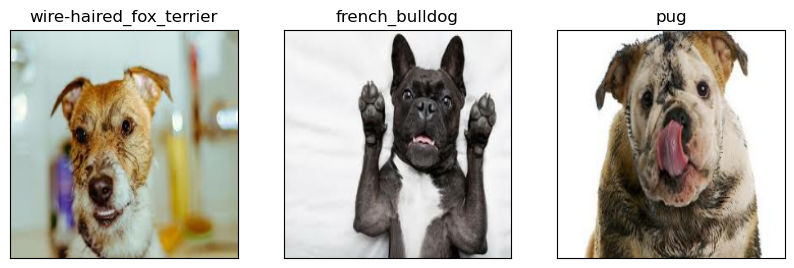

In [23]:
plt.figure(figsize=(10, 10))
for i, img in enumerate(us_images):
    plt.subplot(1, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.title(us_pred_labels[i])
    plt.imshow(img)
plt.show()